<a href="https://colab.research.google.com/github/ccarpenterg/introNLP/blob/master/02a_NLP_and_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP and Neural Networks

In [0]:
!pip install --upgrade tensorflow

In [2]:
import tensorflow as tf

print(tf.__version__)

2.0.0


In [0]:
from tensorflow import keras

import tensorflow_datasets as tfds

import numpy as np


(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k',
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    as_supervised=True,
    with_info=True
)

In [4]:
print(info)

tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=0.1.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Pot

In [5]:
encoder = info.features['text'].encoder

print('Vocabulary size: {}'.format(encoder.vocab_size))

sample_string = 'A great movie!'

encoded_string = encoder.encode(sample_string)

print(encoded_string)

Vocabulary size: 8185
[133, 122, 65, 7962]


In [6]:
for ts in encoded_string:
    print('{} ---> {}'.format(ts, encoder.decode([ts])))

133 ---> A 
122 ---> great 
65 ---> movie
7962 ---> !


In [7]:
print(encoder.decode(encoded_string))

A great movie!


In [8]:
for train_example, train_label in train_data.take(1):
    print(train_example[:7].numpy())
    print(train_label.numpy())

[ 249    4  277  309  560    6 6639]
1


In [9]:
print(encoder.decode(train_example))

As a lifelong fan of Dickens, I have invariably been disappointed by adaptations of his novels.<br /><br />Although his works presented an extremely accurate re-telling of human life at every level in Victorian Britain, throughout them all was a pervasive thread of humour that could be both playful or sarcastic as the narrative dictated. In a way, he was a literary caricaturist and cartoonist. He could be serious and hilarious in the same sentence. He pricked pride, lampooned arrogance, celebrated modesty, and empathised with loneliness and poverty. It may be a cliché, but he was a people's writer.<br /><br />And it is the comedy that is so often missing from his interpretations. At the time of writing, Oliver Twist is being dramatised in serial form on BBC television. All of the misery and cruelty is their, but non of the humour, irony, and savage lampoonery. The result is just a dark, dismal experience: the story penned by a journalist rather than a novelist. It's not really Dickens 

In [0]:
BUFFER_SIZE = 1000

train_batches = (
    train_data
    .shuffle(BUFFER_SIZE)
    .padded_batch(32, tf.compat.v1.data.get_output_shapes(train_data))
)

test_batches = (
    test_data
    .padded_batch(32, tf.compat.v1.data.get_output_shapes(train_data))
)

In [11]:
for batch_example, labels in train_batches.take(2):
    print("Batch shape:", batch_example.shape)
    print("Label shape:", labels.shape)

Batch shape: (32, 1092)
Label shape: (32,)
Batch shape: (32, 1042)
Label shape: (32,)


In [12]:
model = keras.Sequential([
  keras.layers.Embedding(encoder.vocab_size, 16),
  keras.layers.GlobalAveragePooling1D(),
  keras.layers.Dense(16, activation='relu'),
  keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [14]:
training_results = model.fit(train_batches,
                             epochs=15,
                             validation_data=test_batches,
                             validation_steps=30)

Epoch 1/15
782/782 [==============================] - 10s 12ms/step - loss: 0.6410 - accuracy: 0.6664 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/15
782/782 [==============================] - 7s 9ms/step - loss: 0.4066 - accuracy: 0.8568 - val_loss: 0.3654 - val_accuracy: 0.8667
Epoch 3/15
782/782 [==============================] - 7s 9ms/step - loss: 0.3018 - accuracy: 0.8911 - val_loss: 0.3149 - val_accuracy: 0.8750
Epoch 4/15
782/782 [==============================] - 8s 10ms/step - loss: 0.2560 - accuracy: 0.9082 - val_loss: 0.2963 - val_accuracy: 0.8792
Epoch 5/15
782/782 [==============================] - 7s 9ms/step - loss: 0.2254 - accuracy: 0.9194 - val_loss: 0.2921 - val_accuracy: 0.8792
Epoch 6/15
782/782 [==============================] - 7s 9ms/step - loss: 0.2062 - accuracy: 0.9261 - val_loss: 0.2762 - val_accuracy: 0.8854
Epoch 7/15
782/782 [==============================] - 7s 10ms/step - loss: 0.1870 - accuracy: 0.9351 - val_loss: 0.2806 - val_accuracy: 0

In [15]:
loss, accuracy = model.evaluate(test_batches)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 6s 8ms/step - loss: 0.4139 - accuracy: 0.8653
Loss:  0.41391693648484434
Accuracy:  0.86532


In [16]:
training_dict = training_results.history
training_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

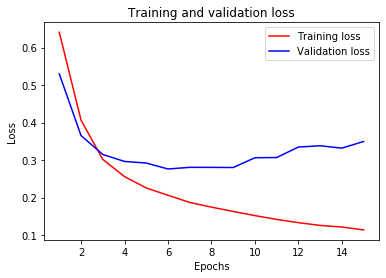

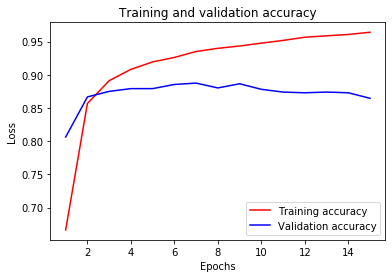

In [17]:
import matplotlib.pyplot as plt

acc = training_dict['accuracy']
val_acc = training_dict['val_accuracy']
loss = training_dict['loss']
val_loss = training_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()